In [6]:
import random
from random import randint
import numpy as np
import csv
from datetime import datetime
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
import matlab.engine
eng = matlab.engine.start_matlab()

In [3]:
EPISODES = 5

In [4]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.9    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(48, activation='relu'))
        model.add(Dense(96, activation='relu'))
        model.add(Dense(48, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state,collision_flag):
        self.memory.append((state, action, reward, next_state,collision_flag))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
      
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, collision_flag in minibatch:
            target = reward
            if not collision_flag:
                target = (reward + self.gamma *
                          np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)


In [8]:
state_size = 1
action_size = 6
agent = DQNAgent(state_size, action_size)


batch_size = 32

now = datetime.now() # current date and time
date_time = now.strftime("%m_%d_%Y_%H_%M_%S")
print(date_time)
directory = os.getcwd()
# path = r'E:\research\1103\Keras deep Q learning\result'
path = directory +'\\result'

fname = path +'\e_'+str(EPISODES)+'_' + date_time+'.csv'
print(fname)

with open(fname, mode='w+', newline='') as csv_file:
    fieldnames = ['episode', 'score', 'epsilon','collision','reward']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()

12_30_2021_21_03_29
i:\Research\1229\traffic-q-learning\traffic-simulator-Q-learning-master\Keras deep Q learning2\result\e_5_12_30_2021_21_03_29.csv


In [10]:

for e in range(1,EPISODES+1):
    num_env_cars = randint(1,5) + 20;  # random car number
    eng.env_ini(num_env_cars,nargout=0)
    
    time = 0
    dist = 0
    score = 0
  
    eng.deep_get_Observation(1,nargout=0)
    collision_flag=False
    
    
    
    for time in range(1,201):
        
        state = eng.deep_obs2state(nargout=1)
    
        state = np.reshape(state, [1, state_size])
        
        eng.old_observation(nargout=0)
        
        action = agent.act(state)
        action=np.asscalar(np.int64(action))
            
        dist=eng.deepQ_update_dynamics(dist,action+1,nargout=1)
            
        collision_flag = eng.deep_check_collision(nargout=1)
            
        eng.deep_get_Observation(1,nargout=0)
            
        reward = eng.deep_get_reward(collision_flag,nargout=1)
            
           
        next_state = eng.deep_obs2state(nargout=1)
            
        next_state = np.reshape(next_state, [1, state_size])
            
            
        agent.remember(state, action, reward, next_state,collision_flag)
            
            
        
        if collision_flag:

            break
    
    score = (dist-4000)/1000;     
    print("episode: {}/{}, score: {}, e: {:.2}, Collision: {}, reward: {}"
              .format(e, EPISODES, score, agent.epsilon,collision_flag,reward))
    
    with open(fname,'a+' , newline='') as f:
        csv_write = csv.writer(f)
        row = [e, score, agent.epsilon,collision_flag,reward]
        csv_write.writerow(row)
    
    if len(agent.memory) > batch_size:
        agent.replay(batch_size)
    if e % 10 == 0:
        agent.save("dqn.h5")
                
        

H:\Users\yanzi\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


episode: 1/5, score: -2.363, e: 1.0, Collision: True, reward: -991.1
episode: 2/5, score: -3.1365, e: 0.99, Collision: True, reward: -1004.5
episode: 3/5, score: -3.94, e: 0.99, Collision: True, reward: -1011.1
episode: 4/5, score: -3.936, e: 0.99, Collision: True, reward: -1012.1
episode: 5/5, score: -3.872, e: 0.98, Collision: True, reward: -1012.1


   episode   score   epsilon  collision  reward
0        1 -2.3630  1.000000       True  -991.1
1        2 -3.1365  0.995000       True -1004.5
2        3 -3.9400  0.990025       True -1011.1
3        4 -3.9360  0.985075       True -1012.1
4        5 -3.8720  0.980150       True -1012.1


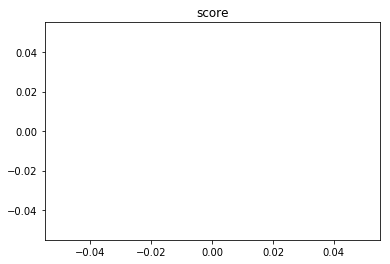

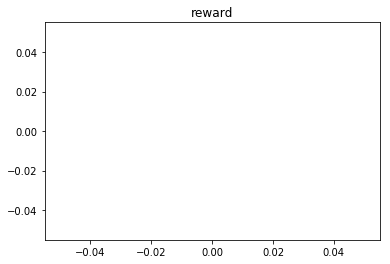

In [12]:

directory = os.getcwd()
path = directory +'\\result\\'
df = pd.read_csv(fname)  
print(df)
bin_num = 1000
x =[]
y= []
i= 'score'
# EPISODES = 1000
for j in range(int(EPISODES/bin_num)):
        x.append(j * bin_num)
        y.append(df[j * bin_num:j * bin_num+(bin_num-1)][i].mean())
plt.title(i)
# plt.legend(i + "_mean")
plt.plot(x, y , label = "v=20")
plt.savefig(path + i +date_time + str(bin_num) +'.png')
plt.show()

i= 'reward'
# EPISODES = 1000
for j in range(int(EPISODES/bin_num)):
        x.append(j * bin_num)
        y.append(df[j * bin_num:j * bin_num+(bin_num-1)][i].mean())
plt.title(i)
# plt.legend(i + "_mean")
plt.plot(x, y , label = "v=20")

plt.savefig(path + i +date_time + str(bin_num) +'.png')
plt.show()

     episode   score   epsilon  collision  reward
0          1 -3.9230  1.000000       True -1000.1
1          2 -3.9400  1.000000       True  -991.0
2          3 -3.9310  1.000000       True -1005.0
3          4 -3.9700  1.000000       True  -993.1
4          5 -3.9720  1.000000       True  -997.1
..       ...     ...       ...        ...     ...
320      321 -2.9625  0.206191       True -1002.6
321      322  0.0495  0.205160      False    -9.6
322      323 -3.9440  0.204135       True  -994.1
323      324 -3.5945  0.203114       True -1008.0
324      325 -3.4955  0.202098       True  -991.1

[325 rows x 5 columns]


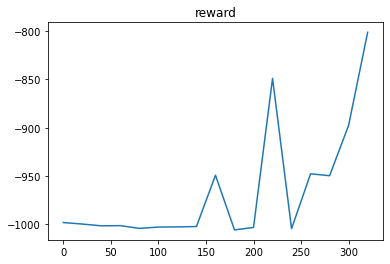

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(r'E:\research\1103\Keras deep Q learning\e_1000_12_13_2021_18_08_30.csv')  

print(df)
bin_num = 20 
x =[]
y= []
i= 'reward'
for j in range(int(EPISODES/bin_num)):
        x.append(j * bin_num)
        y.append(df[j * bin_num:j * bin_num+(bin_num-1)][i].mean())
plt.title(i)
# plt.legend(i + "_mean")
plt.plot(x, y , label = "v=20")
plt.savefig(path + i +date_time + str(bin_num) +'.png')
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(r'E:\research\1120\traffic-simulator-Q-learning-master\Parameters\score_alpha_0.2_episode_10000_w5_0.1_epsilon_decay_v2.csv')  
print(df)
bin_num = 500 
x =[]
y= []
i= 'reward'
for j in range(int(EPISODES/bin_num)):
        x.append(j * bin_num)
        y.append(df[j * bin_num:j * bin_num+(bin_num-1)][i].mean())
plt.title(i)
# plt.legend(i + "_mean")
plt.plot(x, y , label = "v=20")
plt.savefig(path + i +date_time + str(bin_num) +'.png')
plt.show()

      -3.5695
0     -3.9100
1     -3.8595
2     -3.7555
3     -3.6320
4     -3.8850
...       ...
9994   0.8540
9995  -3.1020
9996   1.3600
9997   1.4355
9998   0.7840

[9999 rows x 1 columns]


KeyError: 'reward'